# Training a fully Dockerized License Plate Recognition app with IceVision and Amazon Textract

### Useful commands

* `curl http://127.0.0.1:8000/predict -F "image=@sample_images/car6.jpeg"`
* `curl http://127.0.0.1:8000/`
* `docker stop $(docker ps -a -q)`
* `docker system prune -a`
* `docker build -t car_plates_train .`
* `docker run -it --rm --entrypoint bash --gpus all -v /home/ubuntu/:/root/ car_plates_train`
* `docker run -itd --rm --gpus all -v /home/ubuntu/:/root/ car_plates_train`
* `docker build -t car_plates_serve .`
* `docker run --rm -p 8000:8000 --name=car_plates_serve --gpus all car_plates_serve`


[Data from Kaggle](https://www.kaggle.com/datasets/andrewmvd/car-plate-detection)


## Training logic

### Imports

In [1]:
from icevision.all import *

%matplotlib inline

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Which device are we running on?

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


### Loading and parsing the raw data from Kaggle

In [3]:
data_dir = Path("/root/data/licenses_plates_kaggle/") 

In [4]:
parser = parsers.VOCBBoxParser(annotations_dir=data_dir/"annotations", 
                               images_dir=data_dir/"images")

In [5]:
train_records, valid_records = parser.parse()

100%|██████████| 433/433 [00:00<00:00, 1157.26it/s]
INFO     - Autofixing records | icevision.parsers.parser:parse:122
100%|██████████| 433/433 [00:00<00:00, 17278.74it/s]


In [6]:
print(f"Training model on {len(train_records)} images")
print(f"Training model on {len(valid_records)} images")
print(f"Classes used for modelling {parser.class_map}")

Training model on 346 images
Training model on 87 images
Classes used for modelling <ClassMap: {'background': 0, 'licence': 1}>


### Defining transforms and datasets

In [7]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [8]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

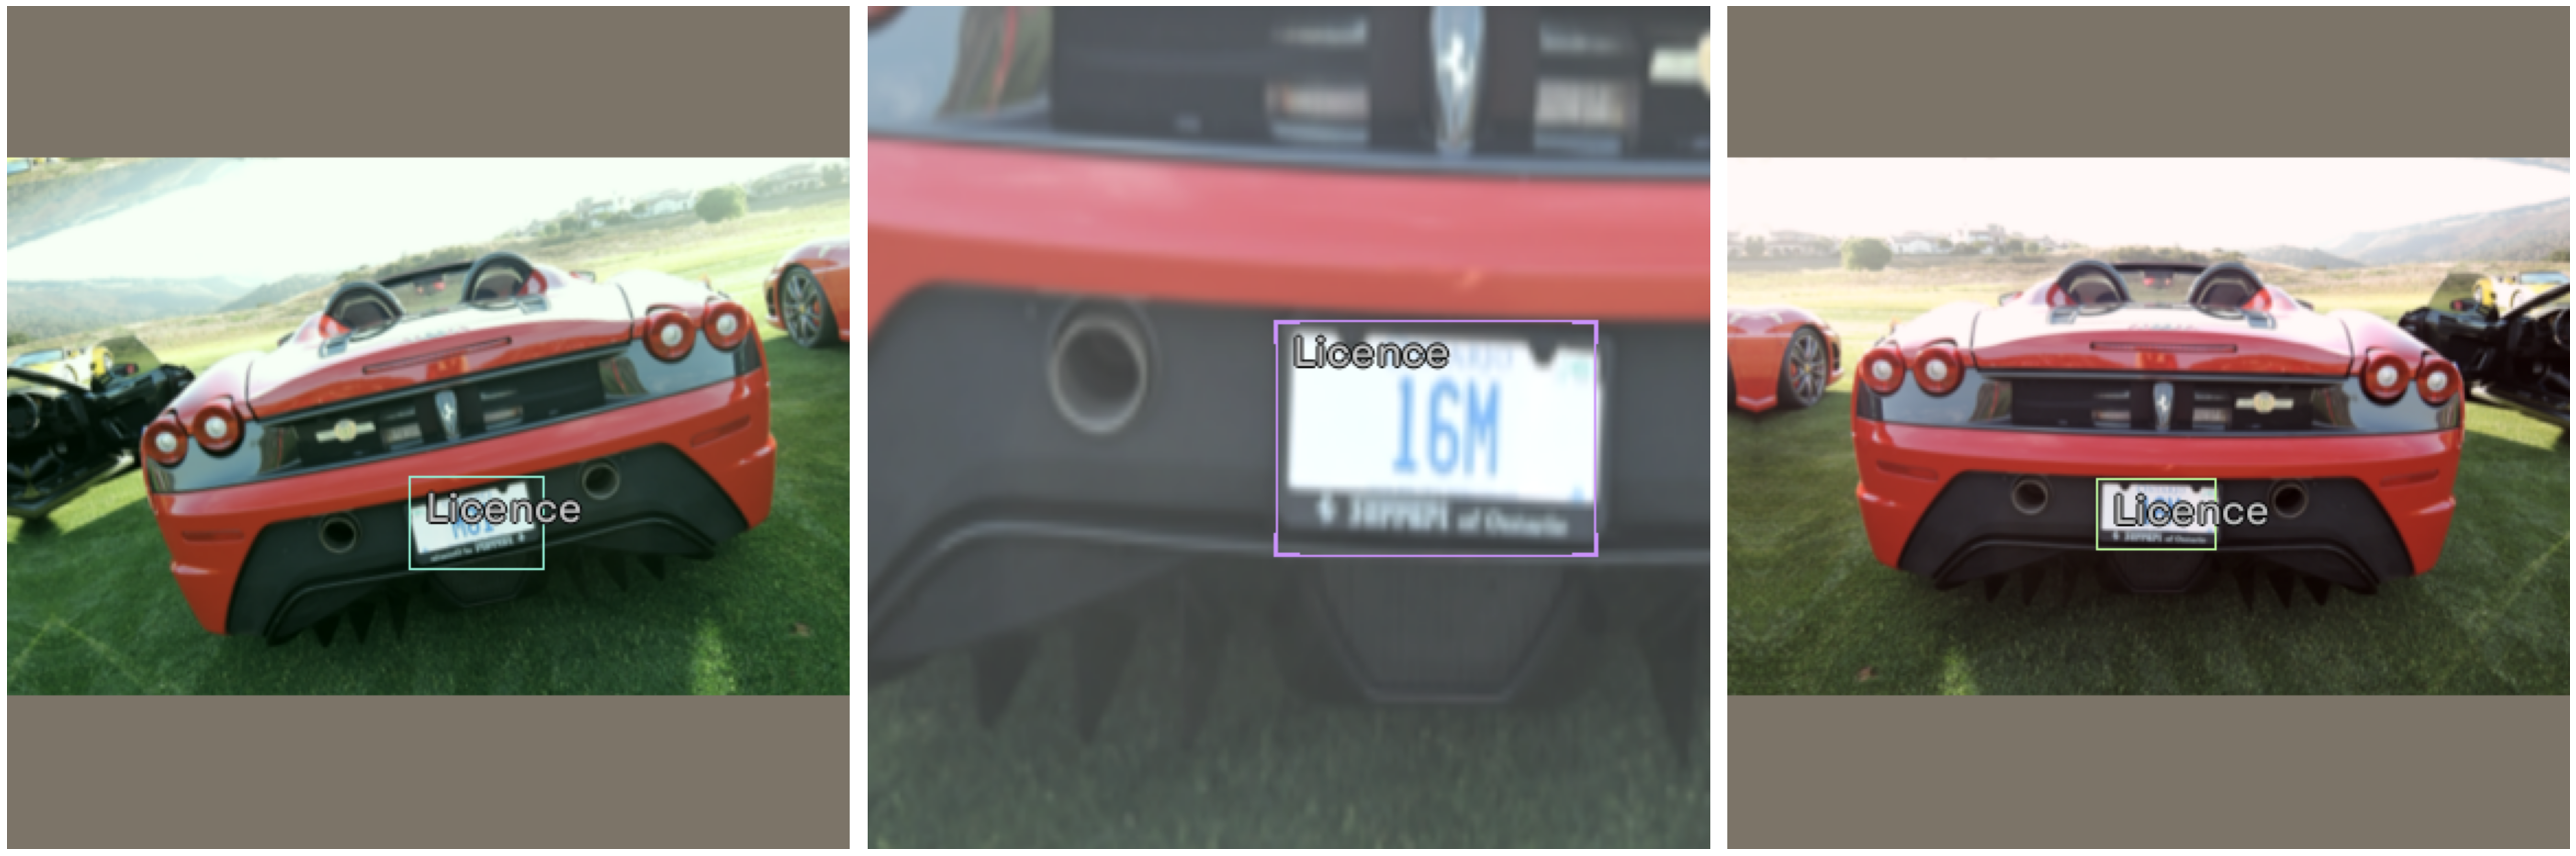

In [10]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

### Defining model: YoloV5 Medium

In [11]:
image_size = 384
extra_args = {}

model_type = models.ultralytics.yolov5
backbone = model_type.backbones.medium
extra_args['img_size'] = image_size

model_type, backbone, extra_args

(<module 'icevision.models.ultralytics.yolov5' from '/usr/local/lib/python3.8/site-packages/icevision/models/ultralytics/yolov5/__init__.py'>,
 {'img_size': 384})

In [ ]:
# Instantiate the model
model = model_type.model(backbone=backbone(pretrained=True), num_classes=2, **extra_args)

# Load a pre-trained one if we don't want to re-train
model.load_state_dict(torch.load("./models/model.pth"))

In [16]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=1, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=1, shuffle=False)

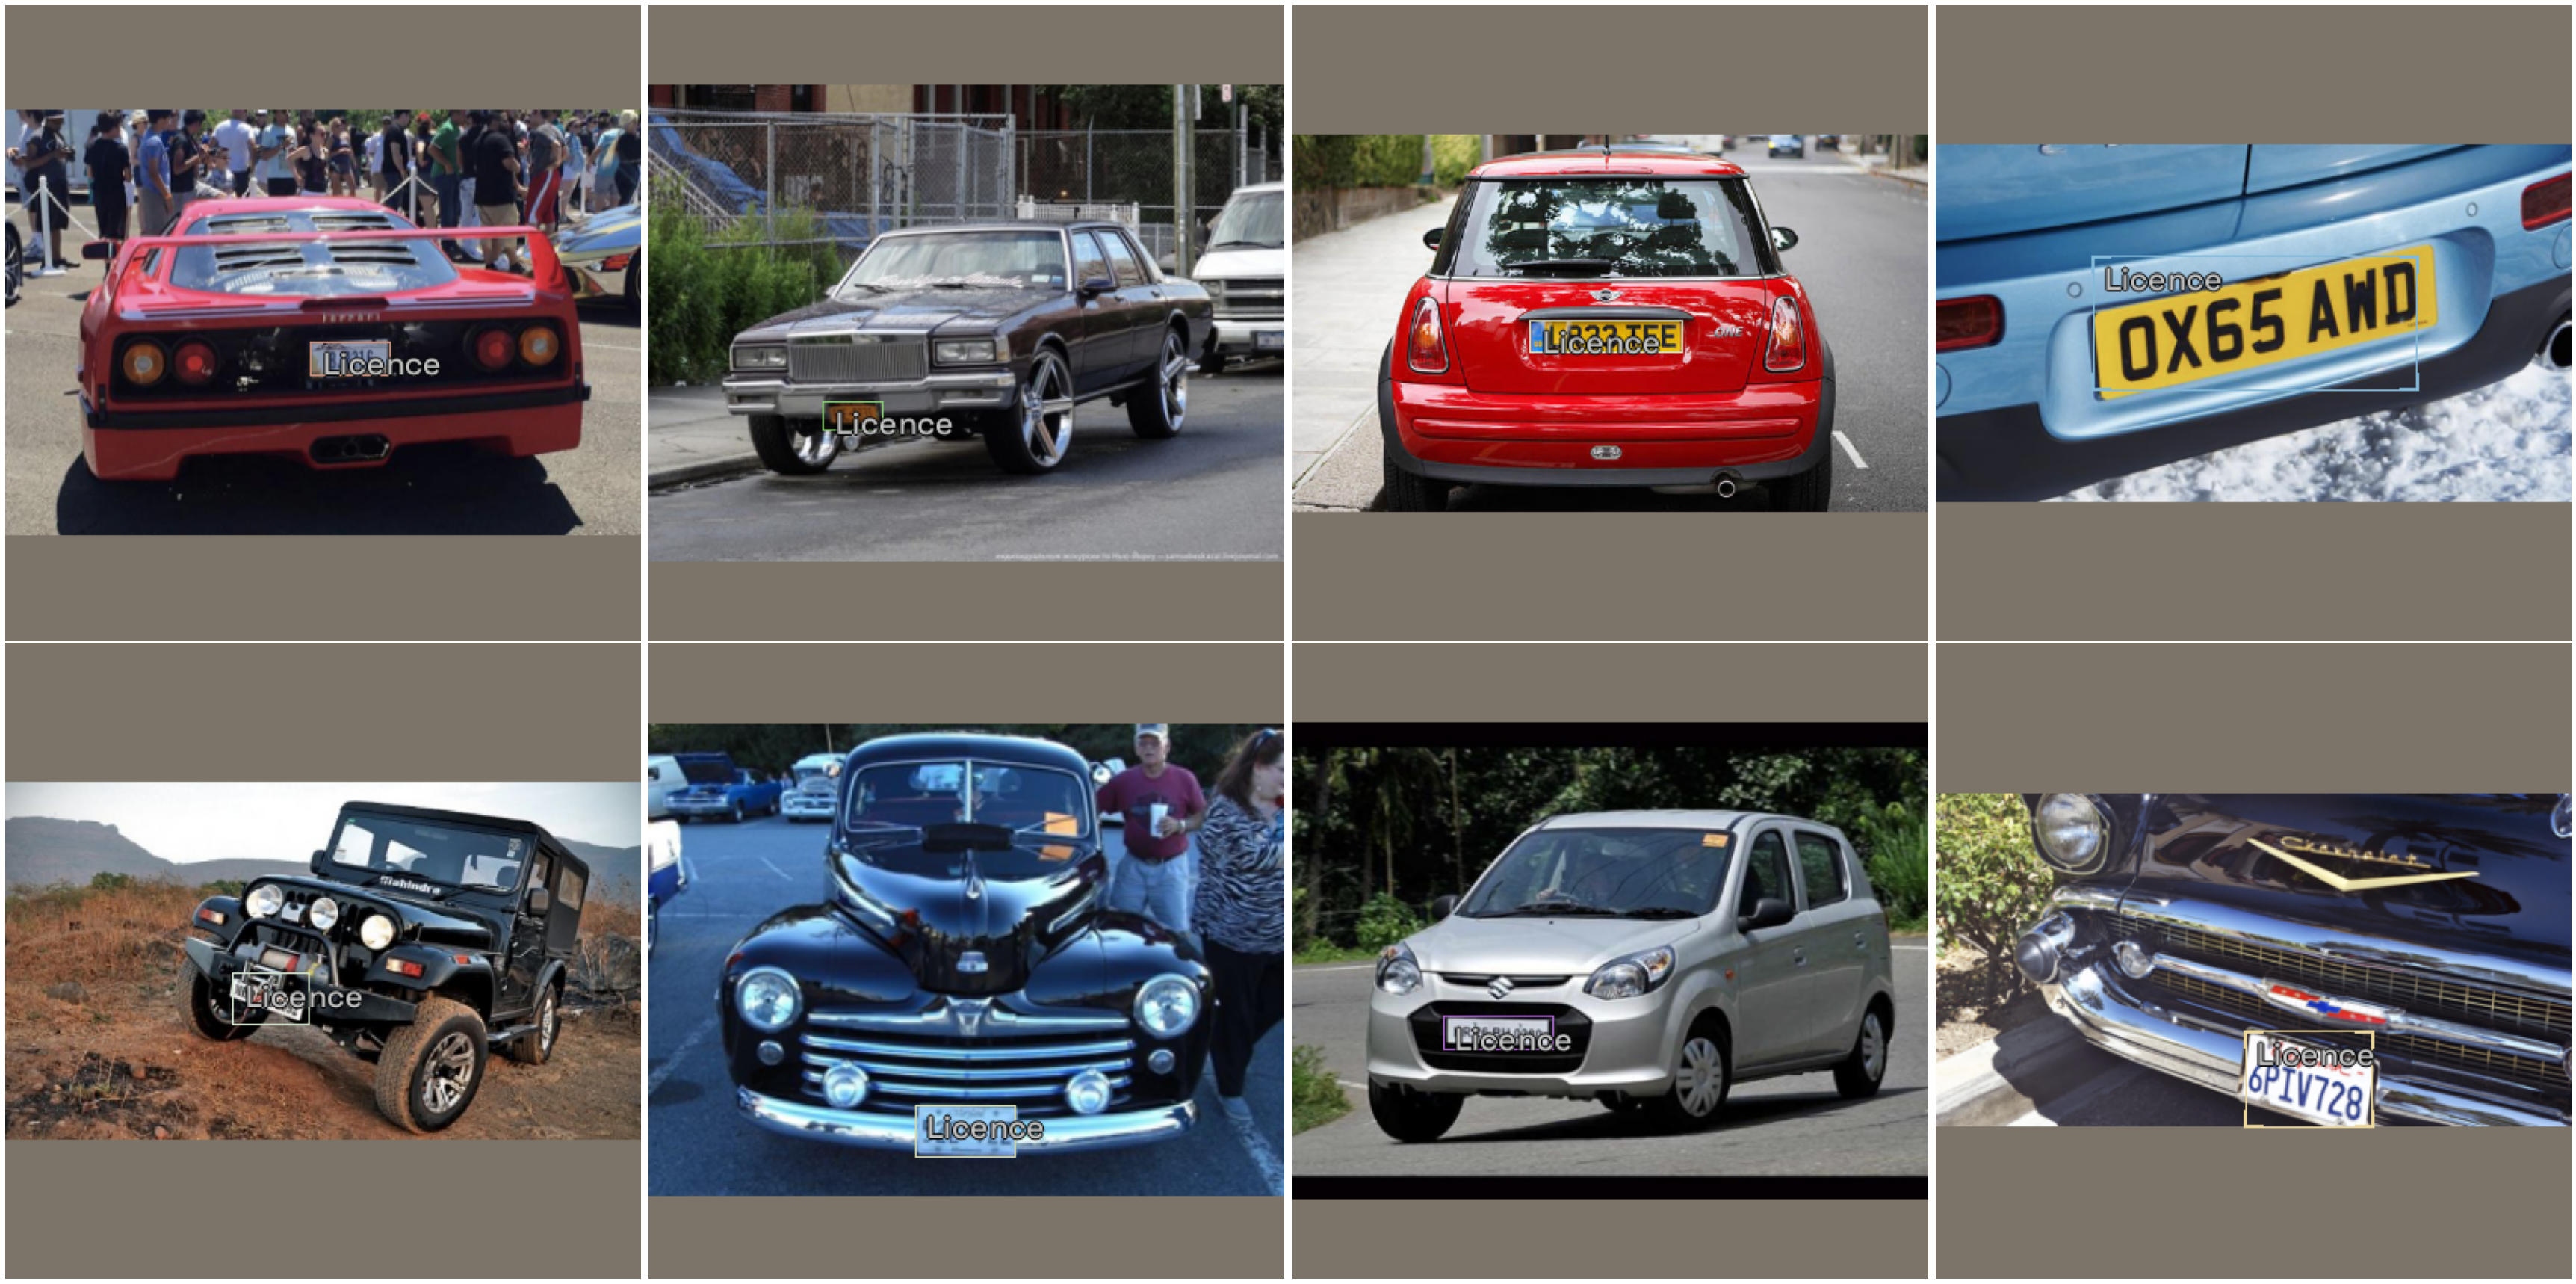

In [17]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

### Training model

In [ ]:
from fastai.callback.tracker import SaveModelCallback

metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]
cbs = SaveModelCallback()

In [ ]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics, cbs=cbs)

SuggestedLRs(valley=0.002511886414140463)

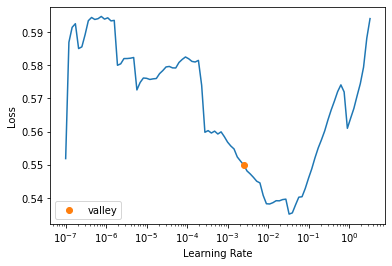

In [18]:
learn.lr_find()

In [19]:
learn.fine_tune(20, 2e-3, freeze_epochs=1)

/usr/local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Better model found at epoch 0 with valid_loss value: 0.4542992115020752.


Better model found at epoch 0 with valid_loss value: 0.39165541529655457.
Better model found at epoch 1 with valid_loss value: 0.33600595593452454.
Better model found at epoch 2 with valid_loss value: 0.2932039201259613.
Better model found at epoch 3 with valid_loss value: 0.24056577682495117.
Better model found at epoch 4 with valid_loss value: 0.2229069173336029.
Better model found at epoch 6 with valid_loss value: 0.21531352400779724.
Better model found at epoch 7 with valid_loss value: 0.2122286707162857.
Better model found at epoch 8 with valid_loss value: 0.2073337286710739.
Better model found at epoch 9 with valid_loss value: 0.19104532897472382.
Better model found at epoch 11 with valid_loss value: 0.18278418481349945.
Better model found at epoch 12 with valid_loss value: 0.17925728857517242.
Better model found at epoch 13 with valid_loss value: 0.17361800372600555.
Better model found at epoch 14 with valid_loss value: 0.1651793122291565.
Better model found at epoch 15 with val

In [ ]:
# Copy model file to `serve` directory
!cp models/model.pth ./serve/

### Checking if model was trained properly: e.g. can it predict effectively on unseen images during training?

/usr/local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


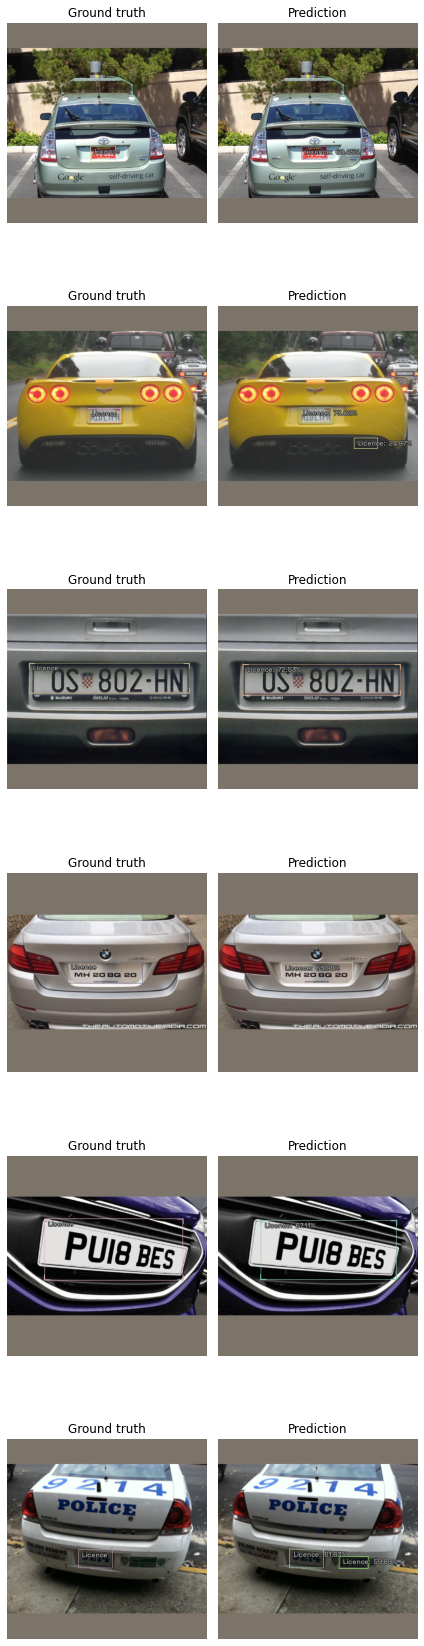

In [13]:
model_type.show_results(model, valid_ds, detection_threshold=.2)

## Serving logic

### Helper functions

In [14]:
from botocore.client import Config
import boto3
from PIL import ImageEnhance, Image
from typing import List, Union, Tuple, Dict
from pprint import pprint

textract = boto3.client('textract', region_name="eu-west-1", config=Config(retries = {'max_attempts': 20, 'mode': 'adaptive'}))

def image_to_bts(frame: np.array) -> bytes:
    '''
    :param frame: WxHx3 ndarray
    '''
    _, bts = cv2.imencode('.jpg', frame)
    bts = bts.tobytes()
    return bts

def crop_and_enhance(img: Image.Image, coords: Tuple[int]) -> Image.Image:
    roi = img.crop(coords).convert('L')
    enhancer = ImageEnhance.Contrast(roi)
    roi = enhancer.enhance(1.5)
    return roi

def extract_coords_from_bbox(bbox: BBox) -> Tuple[int]: return bbox.xmin, bbox.ymin, bbox.xmax, bbox.ymax

def extract_biggest_bbox(bboxes: List[BBox]) -> Union[None, BBox]:
    if len(bboxes) == 0:
        return None
    elif len(bboxes) == 1:
        return bboxes[0]
    else:
        sorted_bboxes_by_area = sorted([(bbox, bbox.area) for bbox in bboxes], key=lambda element: element[1])
        return sorted_bboxes_by_area[-1][0]

def read_text_from_roi(roi: Image.Image, textract) -> Union[None, Dict]:
    image_bytes = image_to_bts(np.array(roi))
    aws_response = textract.detect_document_text(Document={'Bytes': image_bytes})
    result = []
    for block in aws_response["Blocks"]:
        if block["BlockType"] == "LINE":
            bbox = block['Geometry']['BoundingBox']
            result.append({'text': block["Text"], 
                        'confidence': block["Confidence"]/100,
                        'bbox_width': bbox['Width'],
                        'bbox_height': bbox['Height'],
                        'bbox_area': bbox['Width']*bbox['Height']
                        })
    if len(result)>0: return sorted(result, key=lambda element: element['bbox_area'], reverse=True)
    else: return None

### Predict on new image

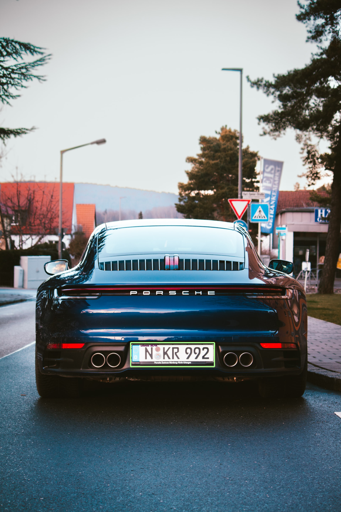

In [15]:
img = PIL.Image.open("./sample_images/car3.jpeg")

infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(384), tfms.A.Normalize()])
class_map = ClassMap(['licence'])
pred_dict  = model_type.end2end_detect(img, infer_tfms, model, 
                                       class_map=class_map, detection_threshold=0.3)

im = pred_dict['img']
im.thumbnail((512, 512))
im

Biggest car plate bbox: <BBox (xmin:735, ymin:1927, xmax:1207, ymax:2062)>
Boox coordinates: (735, 1927, 1207, 2062)
Cropped car plate (B&W + contrast increased)


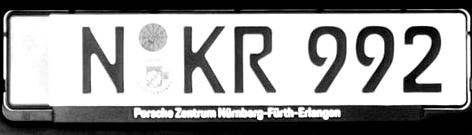

In [22]:
bbox = extract_biggest_bbox(pred_dict["detection"]["bboxes"])
print(f"Biggest car plate bbox: {bbox}")
coords = extract_coords_from_bbox(bbox)
print(f"Boox coordinates: {coords}")
roi = crop_and_enhance(img, coords)
print("Cropped car plate (B&W + contrast increased)")
roi


In [19]:
result = read_text_from_roi(roi, textract)
pprint(result)

[{'bbox_area': 0.30532666751559745,
  'bbox_height': 0.5468825697898865,
  'bbox_width': 0.5583038926124573,
  'confidence': 0.9960591125488282,
  'text': 'KR 992'},
 {'bbox_area': 0.05110330016950826,
  'bbox_height': 0.5070745944976807,
  'bbox_width': 0.10078063607215881,
  'confidence': 0.9946308135986328,
  'text': 'N'}]
